# Machine Learning Pipeline - Feature Engineering

In the following notebooks, we will go through the implementation of each of the steps in the Machine Learning Pipeline.

We will discuss:

1. Data Analysis
2. **Feature Engineering**
3. Feature Selection
4. Model Training
5. Model Evaluation

In [1]:
# to handle datasets
import pandas as pd
import numpy as np

# for plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

# to divide train and test set
from sklearn.model_selection import train_test_split

# feature scaling
from sklearn.preprocessing import MinMaxScaler

# to rank our non-parametric target
from scipy.stats import rankdata

# to visualise all the columns in the dataframe
pd.pandas.set_option('display.max_columns',None)

In [2]:
# load dataset
data = pd.read_csv('CarPrice_Assignment.csv')

In [3]:
# rows and columns of the data
print(f'Number of rows: {data.shape[0]}')
print(f'Number of columns: {data.shape[1]}')

Number of rows: 205
Number of columns: 26


In [4]:
# drop car_ID, it is just an identification number
data = data.drop('car_ID', axis=1)

In [5]:
data.head()

,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,carheight,curbweight,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


# Separate dataset into train and test

It is important to separate our data intro training and testing set. 

When we engineer features, some techniques learn parameters from data. It is important to learn these parameters only from the train set. This is to avoid over-fitting.It is important to separate our data intro training and testing set. 

When we engineer features, some techniques learn parameters from data. It is important to learn these parameters only from the train set. This is to avoid over-fitting.

**Separating the data into train and test involves randomness, therefore, we need to set the seed.**

In [6]:
# Let's separate into train and test set
# Remember to set the seed (random_state for this sklearn function)

X_train, X_test, y_train, y_test = train_test_split(
    data.drop('price',axis=1), # predictive variables
    data['price'], # target
    test_size=0.3, # portion of dataset to allocate to test set
    random_state=0,  # we are setting the seed here
) 

In [7]:
X_train.shape, X_test.shape

((143, 24), (62, 24))

# Feature Engineering

## Target

The price column is not Gaussian. For the sake of simplicity, we will not apply any transformations to the distrubutions and will adopt distrubution-free/nonparametric methods in assessing its relationship with the independent variables.

## Missing Values

The dataset has no missing values as currently constructed.

## Numerical Variable Transformation

### Continuous Variables

A number of the distributions for the independent continuous variables seemed Guassian in the data analysis notebook. Let's apply some normalisation adjustments to them and observe any differences. Note that they remain nonparametric for the purposes of this project.

In [8]:
cont_vars = ['wheelbase',
             'carlength',
             'carwidth',
             'carheight',
             'curbweight',
             'enginesize',
             'boreratio',
             'stroke',
             'compressionratio',
             'horsepower',
             'peakrpm',
             'citympg',
             'highwaympg']

A basic plot of their original distributions:

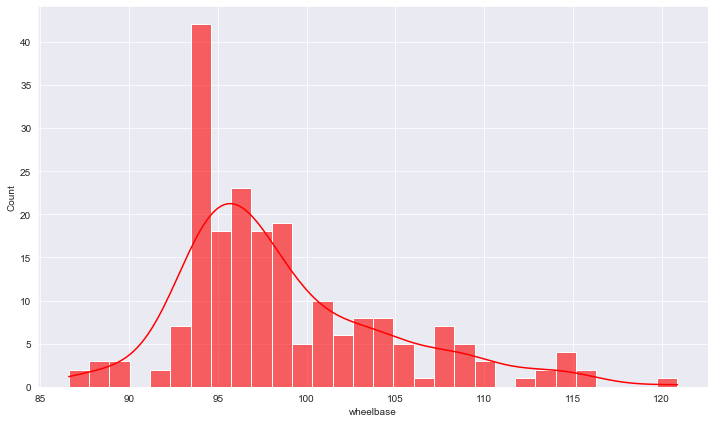

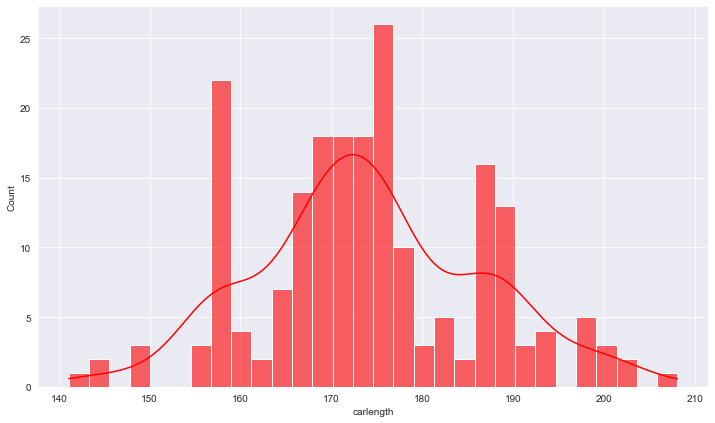

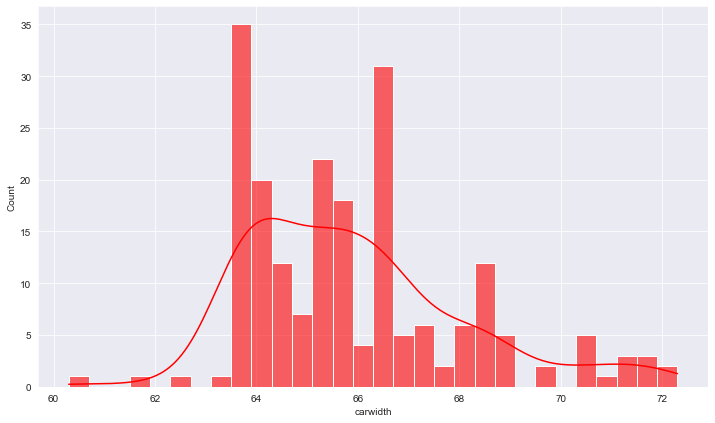

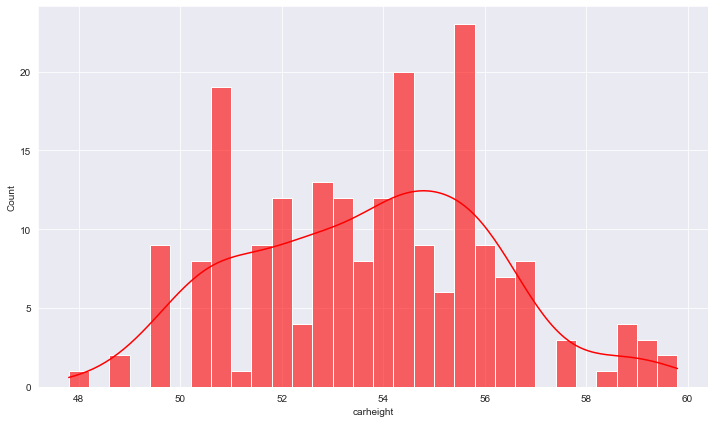

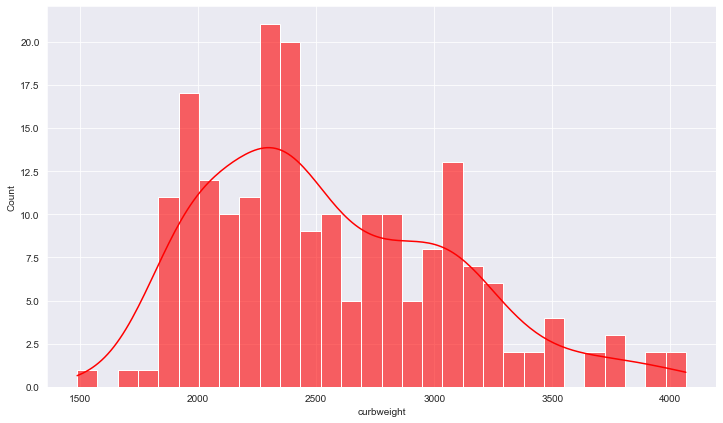

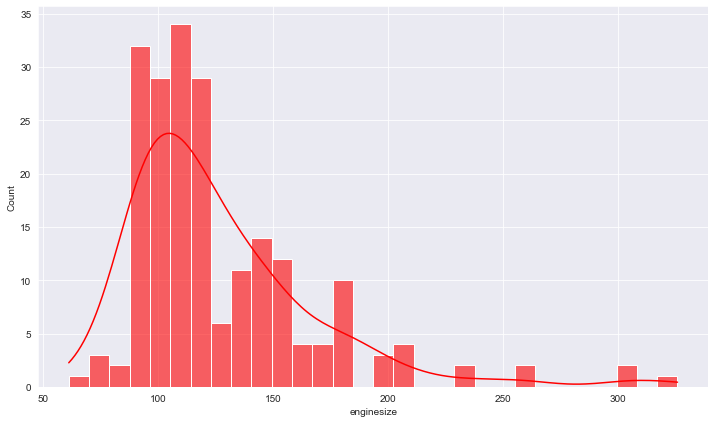

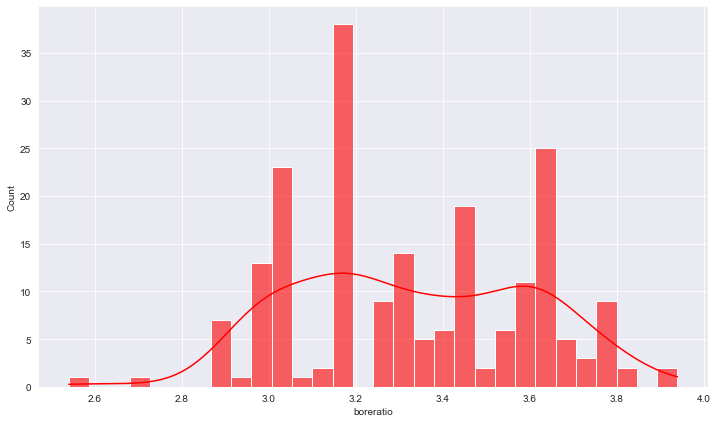

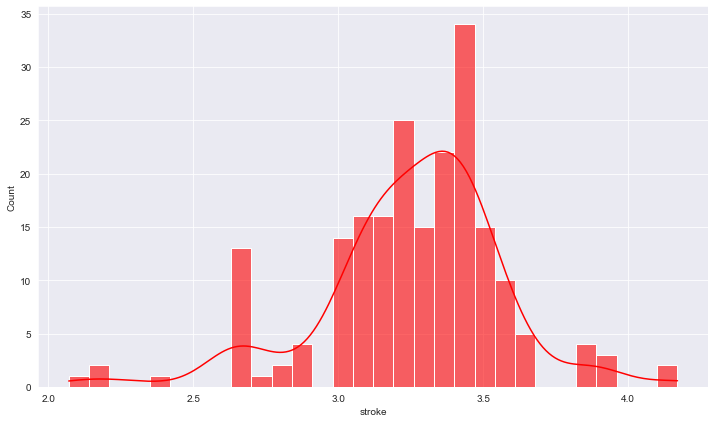

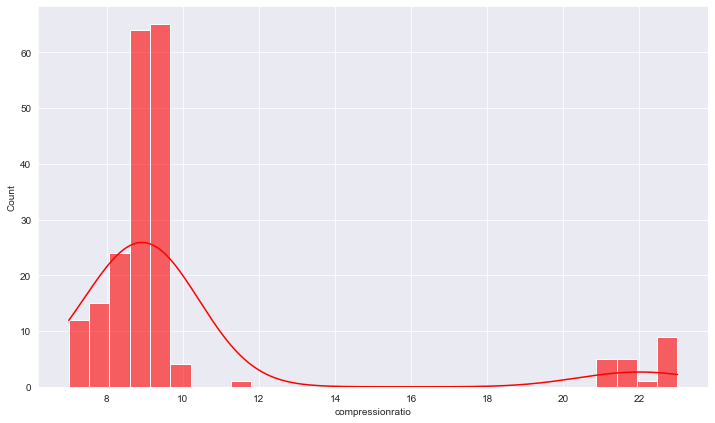

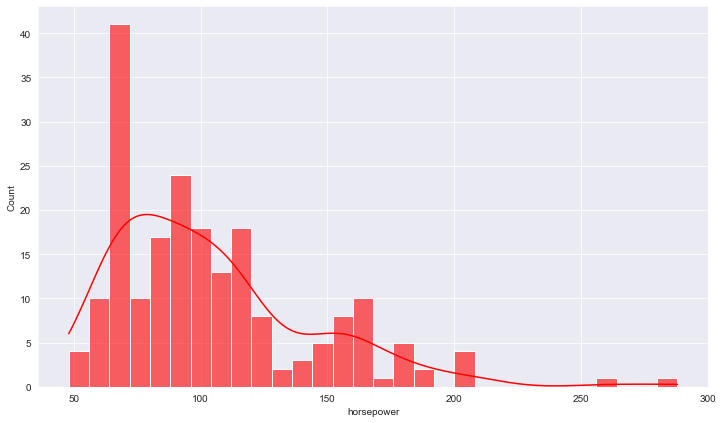

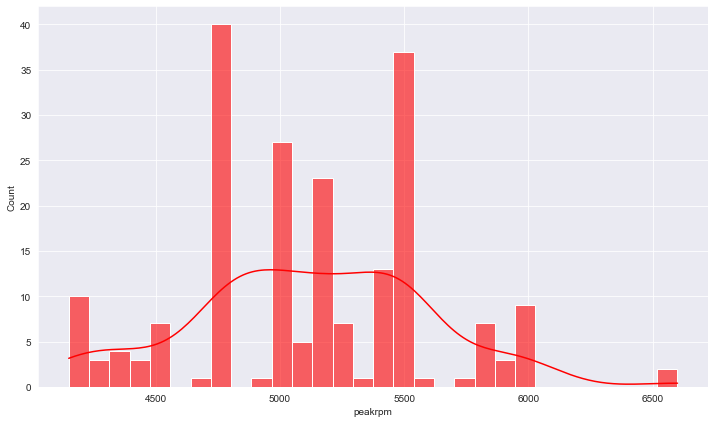

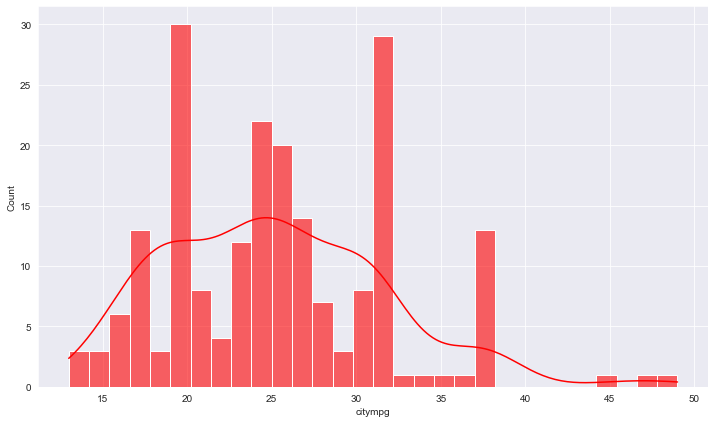

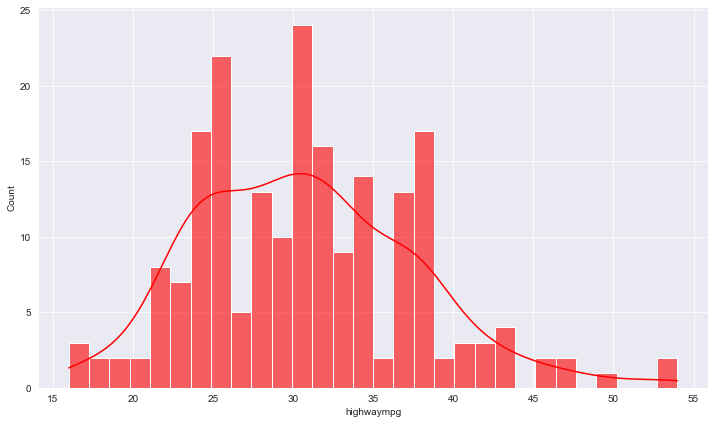

In [9]:
for var in cont_vars:
    plt.figure(figsize=(12,7))
    sns.histplot(x=var, data=data, bins=30, color='red', alpha=0.6, kde=True)

Let's now apply boxcox operations on them with a lambda parameter of -0.5 to achieve a reciprocal square root tarnsformation.

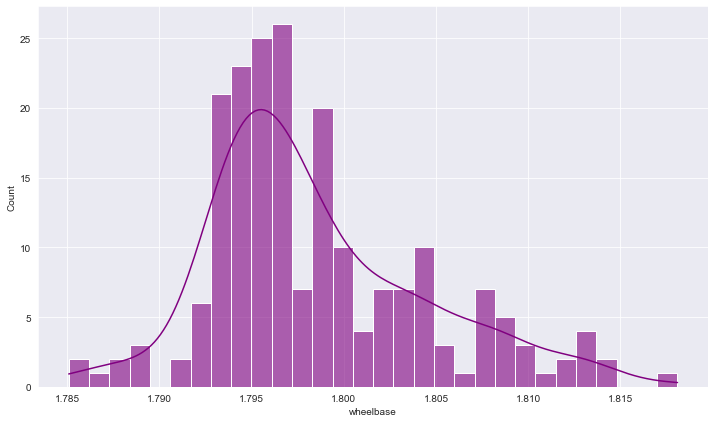

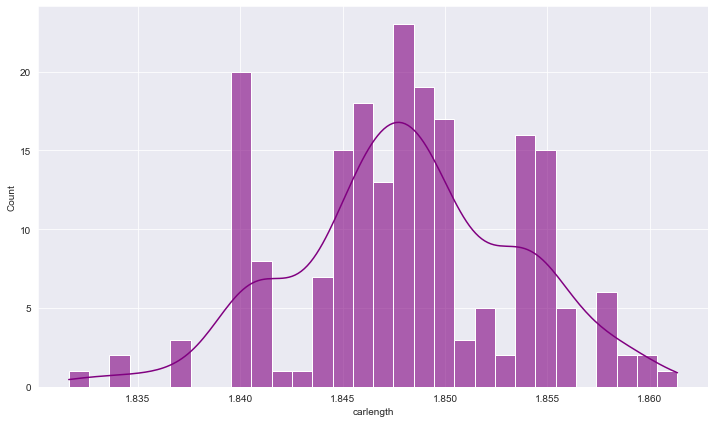

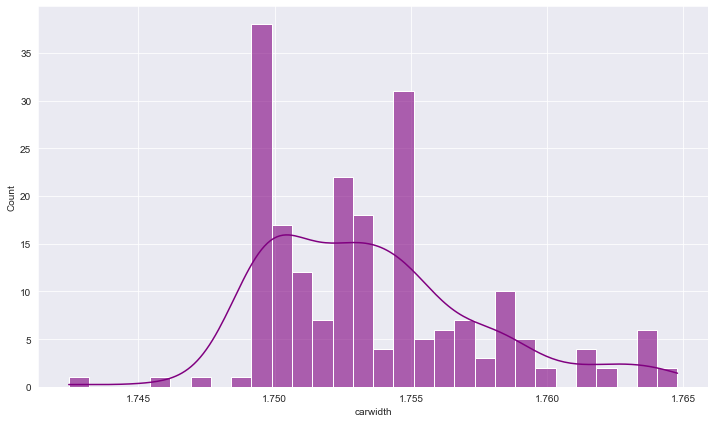

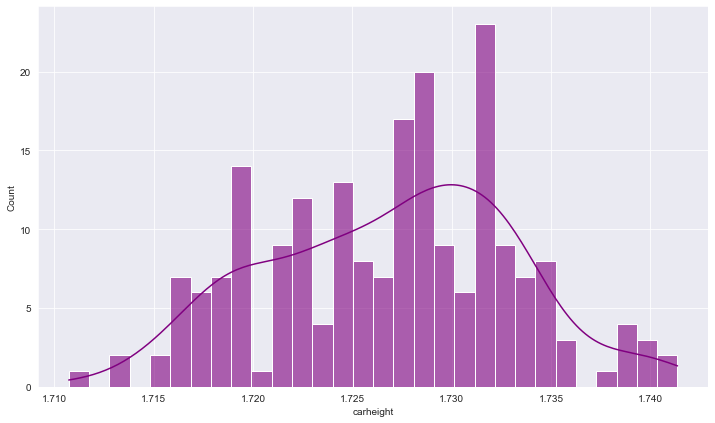

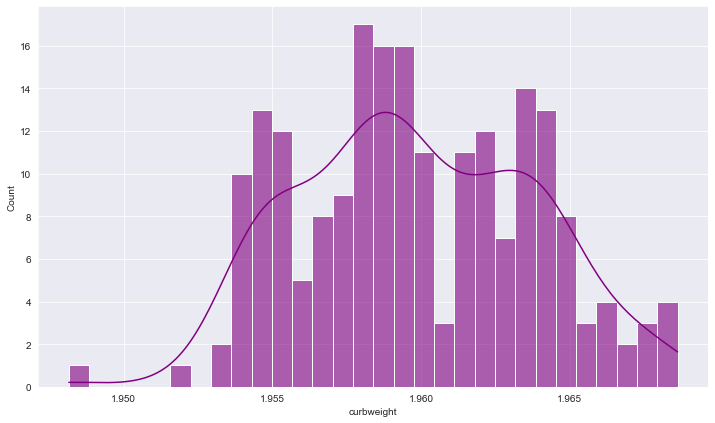

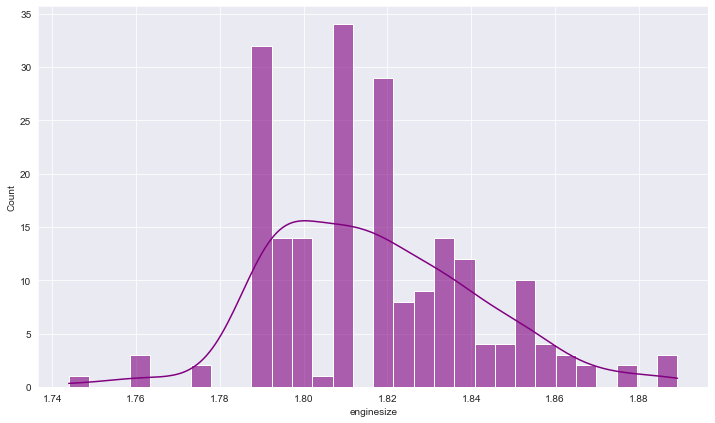

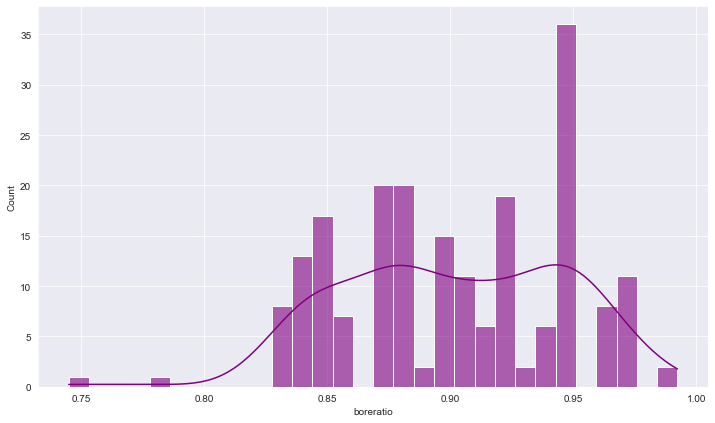

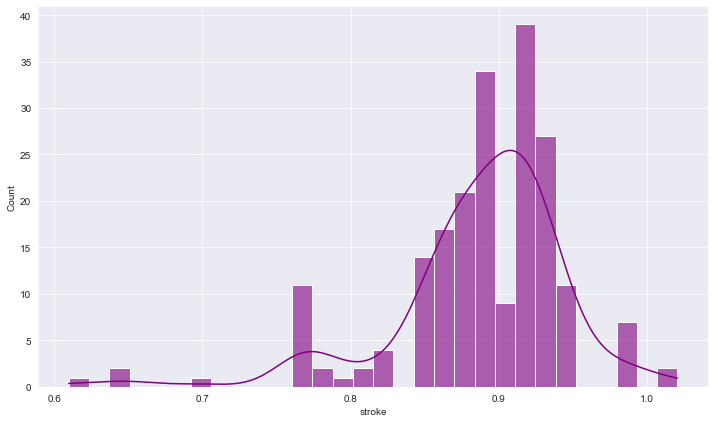

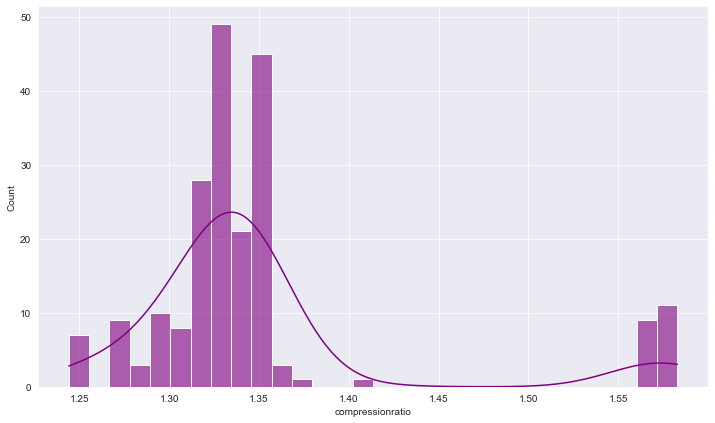

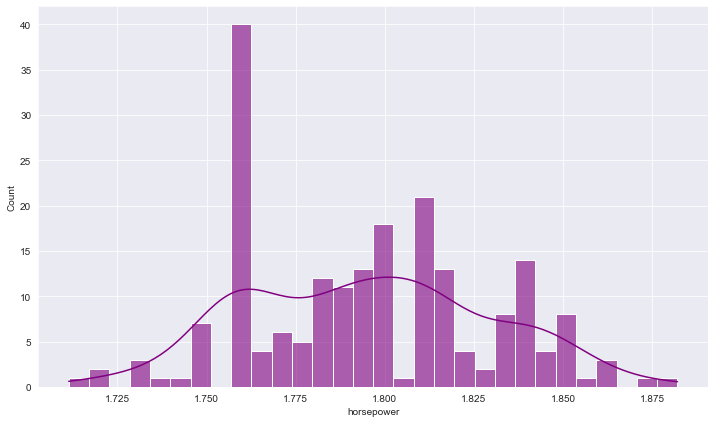

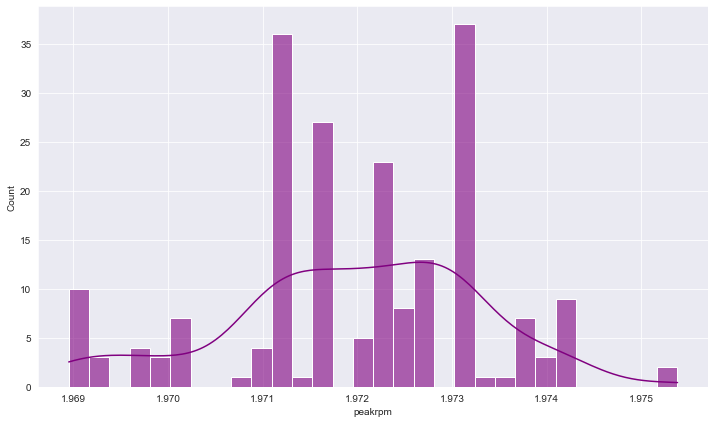

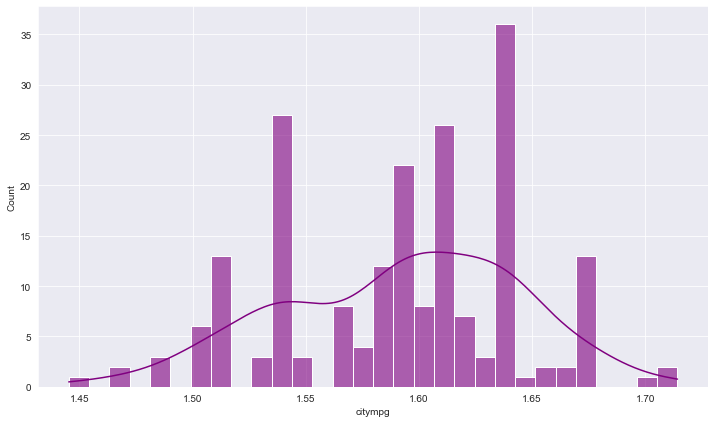

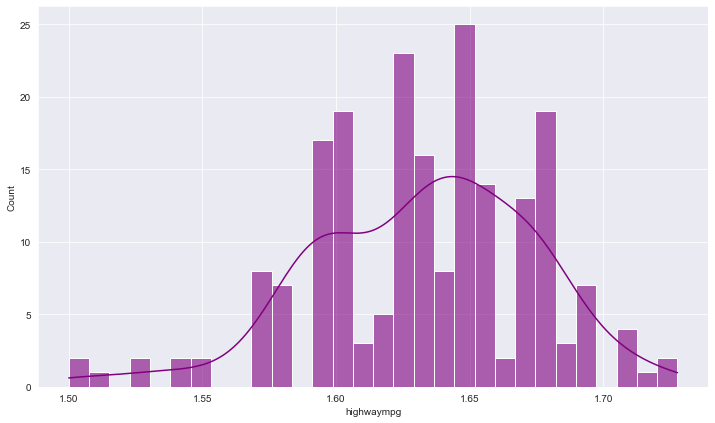

In [10]:
# boxcox dependency
from scipy.stats import boxcox

# make a copy of the dataframe to avoid overwriting
tmp = data.copy()

# iterate over each continuous variable
for var in cont_vars:
    
    # transform each variable
    tmp[var] = boxcox(tmp[var],-0.5)
    
    # plot out the histogram
    plt.figure(figsize=(12,7))
    sns.histplot(x=var, data=tmp, bins=30, color='purple', alpha=0.6, kde=True)

The transformations weren't exactly successful as wide peaks, double peaks, outliers continue to persist. This should validate our decision to use distribution-free methods for our analysis.

## Discrete Variables

The only discrete variable in the dataset is symboling. Symbols are generally used by insurers to indicate vehicle types for which coverage is in effect. They are typically numbered 1 - 6. In this dataset, they have actually been numbered from -2 to 3. We are going to re-assign the numberings to reflect the domain reality.

<AxesSubplot:xlabel='symboling', ylabel='count'>

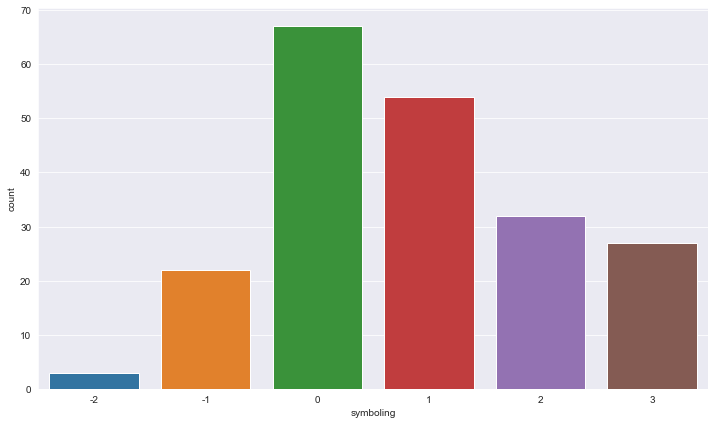

In [11]:
plt.figure(figsize=(12,7))
sns.countplot(x='symboling',data=data)

Most of the cars in the dataset are covered under the 0 and 1 symbol - this would typically be the 3 and 4 symbols which indicate 'Owned Private Passenger Autos' and 'Owned Autos other than Private Passenger' respectively.

In [12]:
# re-assignment operation
symbol_mappings = {-2: 1, -1: 2, 0: 3, 1: 4, 2: 5, 3: 6}

X_train['symboling'] = X_train['symboling'].map(symbol_mappings)
X_test['symboling'] = X_test['symboling'].map(symbol_mappings)

In [13]:
# confirm label re-assignment
X_train['symboling'].value_counts()

3    51
4    35
2    19
6    18
5    18
1     2
Name: symboling, dtype: int64

## Categorical Variables

### Adjust CarName cardinality

We indicated during data analysis that our CarName column had:
- spelling errors, and
- too many values for a categorical column

We will correct the spelling errors and then collapse the cardinality of the column to reflect the home countries of the cars' manufacturers.

In [14]:
cat_vars = ['CarName',
            'fueltype',
            'aspiration',
            'doornumber',
            'carbody',
            'drivewheel',
            'enginelocation',
            'cylindernumber',
            'enginetype',
            'fuelsystem']

In [15]:
# split the car name to isolate the brand names
X_train['CarName'] = X_train['CarName'].apply(lambda x:x.split()[0])
X_test['CarName'] = X_test['CarName'].apply(lambda x:x.split()[0])

In [16]:
# function to correct the spellings
def check_spelling(x):
    if x == 'alfa-romero':
        return 'alfa-romeo'
    elif x == 'maxda':
        return 'mazda'
    elif x == 'Nissan':
        return 'nissan'
    elif x == 'porcshce':
        return 'porsche'
    elif x == 'toyouta':
        return 'toyota'
    elif x in ['vokswagen','vw']:
        return 'volkswagen'
    else:
        return x

In [17]:
# apply spell check
X_train['CarName'] = X_train['CarName'].apply(check_spelling)
X_test['CarName'] = X_test['CarName'].apply(check_spelling)

In [18]:
# list of original countries of the auto brands
italy = ['alfa-romeo']
germany = ['audi','bmw','porsche','volkswagen']
usa = ['chevrolet','dodge','buick','mercury','plymouth']
japan = ['honda','isuzu','mazda','mitsubishi','nissan','subaru','toyota']
uk = ['jaguar']
france = ['peugeot','renault']
sweden = ['saab','volvo']

In [19]:
# function to assign country
def assign_country(x):
    if x in italy:
        return 'Italy'
    elif x in germany:
        return 'Germany'
    elif x in usa:
        return 'USA'
    elif x in japan:
        return 'Japan'
    elif x in uk:
        return 'United Kingdom'
    elif x in france:
        return 'France'
    elif x in sweden:
        return 'Sweden'

In [20]:
# apply country naming
X_train['CarName'] = X_train['CarName'].apply(assign_country)
X_test['CarName'] = X_test['CarName'].apply(assign_country)

In [21]:
# confirm naming operation
X_train['CarName'].value_counts()

Japan             76
USA               20
Germany           19
Sweden            13
France             9
Italy              3
United Kingdom     3
Name: CarName, dtype: int64

In [22]:
# rename the column to country
X_train = X_train.rename(columns={'CarName':'country'})
X_test = X_test.rename(columns={'CarName':'country'})

### Removing Rare Labels

For the remaining categorical variables, we will group those categories that are present in less than 1% of the observations. That is, all values of categorical variables that are shared by less than 1% of houses, well be replaced by the string "Rare".

In [23]:
# list out all categorical variables
cat_vars = ['country',
            'fueltype',
            'aspiration',
            'doornumber',
            'carbody',
            'drivewheel',
            'enginelocation',
            'cylindernumber',
            'enginetype',
            'fuelsystem']

In [24]:
def find_frequent_labels(df, var, rare_perc):
    
    # function finds the labels shared by more than
    # a certain % of the houses in the dataset
    
    df = df.copy()
    
    tmp = df.groupby(var)[var].count() / len(df)
    
    return tmp[tmp > rare_perc].index

In [25]:
for var in cat_vars:
    
    # find the frequent categories
    frequent_ls = find_frequent_labels(X_train, var, 0.01)
    
    print(var, frequent_ls)
    print()
    
    # replace rare categories by the string 'Rare'
    X_train[var] = np.where(X_train[var].isin(
        frequent_ls), X_train[var], 'Rare')
    
    X_test[var] = np.where(X_test[var].isin(
        frequent_ls), X_test[var], 'Rare')

country Index(['France', 'Germany', 'Italy', 'Japan', 'Sweden', 'USA',
       'United Kingdom'],
      dtype='object', name='country')

fueltype Index(['diesel', 'gas'], dtype='object', name='fueltype')

aspiration Index(['std', 'turbo'], dtype='object', name='aspiration')

doornumber Index(['four', 'two'], dtype='object', name='doornumber')

carbody Index(['convertible', 'hardtop', 'hatchback', 'sedan', 'wagon'], dtype='object', name='carbody')

drivewheel Index(['4wd', 'fwd', 'rwd'], dtype='object', name='drivewheel')

enginelocation Index(['front', 'rear'], dtype='object', name='enginelocation')

cylindernumber Index(['eight', 'five', 'four', 'six', 'two'], dtype='object', name='cylindernumber')

enginetype Index(['dohc', 'l', 'ohc', 'ohcf', 'ohcv', 'rotor'], dtype='object', name='enginetype')

fuelsystem Index(['1bbl', '2bbl', '4bbl', 'idi', 'mpfi', 'spdi'], dtype='object', name='fuelsystem')



In [26]:
for var in cat_vars:
    print(f'train_{var}: {X_train[var].unique()}')
    print(f'test_{var}: {X_test[var].unique()}')
    print()

train_country: ['Japan' 'USA' 'Germany' 'France' 'Sweden' 'Italy' 'United Kingdom']
test_country: ['Japan' 'Germany' 'USA' 'France' 'Sweden']

train_fueltype: ['gas' 'diesel']
test_fueltype: ['gas' 'diesel']

train_aspiration: ['std' 'turbo']
test_aspiration: ['std' 'turbo']

train_doornumber: ['four' 'two']
test_doornumber: ['two' 'four']

train_carbody: ['sedan' 'hatchback' 'wagon' 'hardtop' 'convertible']
test_carbody: ['hatchback' 'wagon' 'sedan' 'hardtop' 'convertible']

train_drivewheel: ['fwd' 'rwd' '4wd']
test_drivewheel: ['fwd' 'rwd' '4wd']

train_enginelocation: ['front' 'rear']
test_enginelocation: ['front']

train_cylindernumber: ['four' 'two' 'six' 'five' 'eight' 'Rare']
test_cylindernumber: ['four' 'six' 'five' 'Rare' 'eight' 'two']

train_enginetype: ['ohc' 'rotor' 'ohcv' 'ohcf' 'l' 'dohc']
test_enginetype: ['ohc' 'dohc' 'l' 'ohcv' 'Rare' 'rotor' 'ohcf']

train_fuelsystem: ['1bbl' '2bbl' '4bbl' 'mpfi' 'idi' 'Rare' 'spdi']
test_fuelsystem: ['2bbl' 'mpfi' '1bbl' '4bbl' 'id

### Encoding of categorical variables

We need to transform the strings of the categorical variables into numbers. Note that we have two kinds of categorical variables - binary and non-binary.

We will apply one-hot encoding on our binary features. For the non-binary features, we will transform the strings into numbers that capture the monotonic relationship between the category and the target.

#### Binary variables

In [27]:
binary_vars = [var for var in cat_vars if X_train[var].nunique() == 2]
binary_vars

['fueltype', 'aspiration', 'doornumber', 'enginelocation']

In [28]:
# function to encode categorical variables

def category_encoder(X,variables):
        
        # loop over each feature in the list
        for feature in variables:
            
            dummies = pd.get_dummies(X[feature],drop_first=True) # grab the dummies
            for column in dummies.columns: # loop over the columns in the dummies dataframe
                dummies = dummies.rename(columns={column:feature + '_' + column}) # affix the feature name to the column name to make it easily identifiable
            X = pd.concat([X,dummies],axis=1) # concat the dummy to the original dataframe
            X = X.drop(feature,axis=1) # drop the string column
        return X # return the dataframe

In [29]:
X_train = category_encoder(X_train,binary_vars)
X_test = category_encoder(X_test,binary_vars)

In [30]:
# sanity check after drop-one operation
for feat in X_train.columns:
    if feat not in X_test.columns:
        print(feat)

enginelocation_rear


In [31]:
X_train['enginelocation_rear'].value_counts()

0    140
1      3
Name: enginelocation_rear, dtype: int64

In [32]:
X_train = X_train.drop('enginelocation_rear',axis=1)

In [33]:
for feat in X_train.columns:
    if feat not in X_test.columns:
        print(feat)

#### Non-binary variables

Next, we will transform the strings of the non-binary categorical variables into numbers that we capture the monotonic relationship between the label and the target.

In [34]:
non_binary_vars = [var for var in cat_vars if var not in binary_vars]
non_binary_vars

['country',
 'carbody',
 'drivewheel',
 'cylindernumber',
 'enginetype',
 'fuelsystem']

We rank the cars by their prices and encode the variables by their rank sums. i.e. the higher the rank sum, the higher the variable's value. The lowest ranked categories have a value of 1.

In [35]:
tmp = pd.concat([X_train, y_train], axis=1)
ranked = rankdata(tmp['price'])
tmp['rank'] = ranked
tmp.head()

,symboling,country,carbody,drivewheel,wheelbase,carlength,carwidth,carheight,curbweight,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,fueltype_gas,aspiration_turbo,doornumber_two,price,rank
40,3,Japan,sedan,fwd,96.5,175.4,62.5,54.1,2372,ohc,four,110,1bbl,3.15,3.580,9.0,86,5800,27,33,1,0,0,10295.0,73.0
60,3,Japan,sedan,fwd,98.8,177.8,66.5,55.5,2410,ohc,four,122,2bbl,3.39,3.390,8.6,84,4800,26,32,1,0,0,8495.0,50.0
56,6,Japan,hatchback,rwd,95.3,169.0,65.7,49.6,2380,rotor,two,70,4bbl,3.33,3.255,9.4,101,6000,17,23,1,0,1,11845.0,80.0
101,3,Japan,sedan,fwd,100.4,181.7,66.5,55.1,3095,ohcv,six,181,mpfi,3.43,3.270,9.0,152,5200,17,22,1,0,0,13499.0,94.5
86,4,Japan,sedan,fwd,96.3,172.4,65.4,51.6,2405,ohc,four,122,2bbl,3.35,3.460,8.5,88,5000,25,32,1,0,0,8189.0,45.0


In [36]:
for var in non_binary_vars:
    
    ordered_labels = tmp.groupby([var])['rank'].sum().sort_values().index
    ordinal_label = {k: i for i, k in enumerate(ordered_labels, 1)}
    
    print(f'{var}: {ordinal_label}')
    
    X_train[var] = X_train[var].map(ordinal_label)
    X_test[var] = X_test[var].map(ordinal_label)

country: {'Italy': 1, 'United Kingdom': 2, 'France': 3, 'USA': 4, 'Sweden': 5, 'Germany': 6, 'Japan': 7}
carbody: {'hardtop': 1, 'convertible': 2, 'wagon': 3, 'hatchback': 4, 'sedan': 5}
drivewheel: {'4wd': 1, 'fwd': 2, 'rwd': 3}
cylindernumber: {'Rare': 1, 'two': 2, 'eight': 3, 'five': 4, 'six': 5, 'four': 6}
enginetype: {'rotor': 1, 'ohcf': 2, 'l': 3, 'dohc': 4, 'ohcv': 5, 'ohc': 6}
fuelsystem: {'Rare': 1, '4bbl': 2, '1bbl': 3, 'spdi': 4, '2bbl': 5, 'idi': 6, 'mpfi': 7}


In [37]:
X_train[non_binary_vars].head()

,country,carbody,drivewheel,cylindernumber,enginetype,fuelsystem
40,7,5,2,6,6,3
60,7,5,2,6,6,5
56,7,4,3,2,1,2
101,7,5,2,5,5,7
86,7,5,2,6,6,5


To illustrate the monotonic relationship between the variables and the target:

In [38]:
X_train['rank'] = tmp['rank']

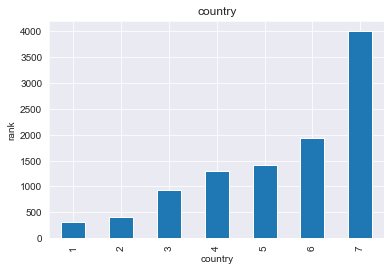

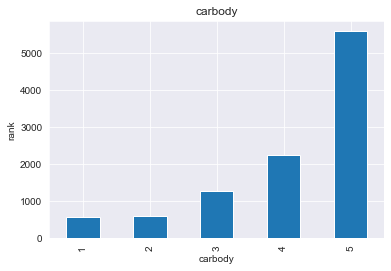

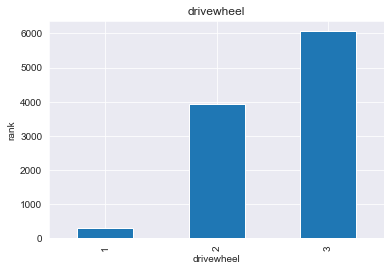

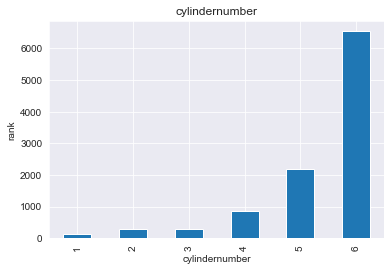

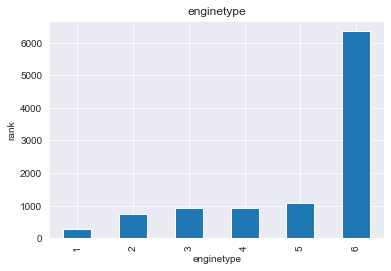

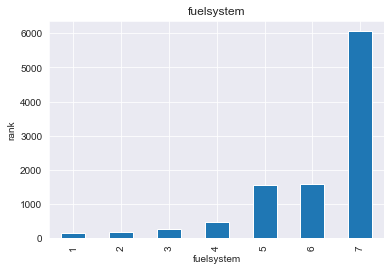

In [39]:
def analyse_vars(X_train, var):
    
    X_train.groupby(var)['rank'].sum().plot.bar()
    plt.title(var)
    plt.ylabel('rank')
    plt.show()

for var in non_binary_vars:
    analyse_vars(X_train,var)

- Price ranks from japanase cars far outweight the rank sums of the other countries in the group.
- 4-cylinder cars also very valuable (per price rankings) - ranking twice as much as the next most expensive cylinder type, i.e. 6-cylinder cars.
- Cars with the mpfi fuel system also seem to be pricier than other cars in their group. Per price rankings, they rank six times as much as the next expensive car in the group.

In [40]:
X_train.head()

,symboling,country,carbody,drivewheel,wheelbase,carlength,carwidth,carheight,curbweight,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,fueltype_gas,aspiration_turbo,doornumber_two,rank
40,3,7,5,2,96.5,175.4,62.5,54.1,2372,6,6,110,3,3.15,3.580,9.0,86,5800,27,33,1,0,0,73.0
60,3,7,5,2,98.8,177.8,66.5,55.5,2410,6,6,122,5,3.39,3.390,8.6,84,4800,26,32,1,0,0,50.0
56,6,7,4,3,95.3,169.0,65.7,49.6,2380,1,2,70,2,3.33,3.255,9.4,101,6000,17,23,1,0,1,80.0
101,3,7,5,2,100.4,181.7,66.5,55.1,3095,5,5,181,7,3.43,3.270,9.0,152,5200,17,22,1,0,0,94.5
86,4,7,5,2,96.3,172.4,65.4,51.6,2405,6,6,122,5,3.35,3.460,8.5,88,5000,25,32,1,0,0,45.0


In [41]:
X_train = X_train.drop('enginetype',axis=1)
X_test = X_test.drop('enginetype',axis=1)

In [42]:
# let's now save the train and test sets for the next notebook!

X_train.to_csv('xtrain_unscaled.csv', index=False)
X_test.to_csv('xtest_unscaled.csv', index=False)

y_train.to_csv('ytrain.csv', index=False)
y_test.to_csv('ytest.csv', index=False)